In [2]:
"""
=============================================================================
UYGULAMA 6: SHAP — Tam Model Yorumlama Kütüphanesi
=============================================================================
Kapsam:
  - shap.TreeExplainer ile hızlı hesaplama
  - summary_plot (bee-swarm) — Global feature importance
  - bar_plot — Ortalama |SHAP| sıralaması
  - waterfall_plot — Tek örnek kademeli katkı
  - force_plot — Bireysel tahmin görselleştirme (matplotlib=True)
  - dependence_plot — Feature etkileşim analizi
  - SHAP Decision Plot — Karar yolu görselleştirme
  - SHAP Interaction Values (gelişmiş)
  - Yanlış Sınıflandırılan Örneklerin SHAP Analizi

Veri: Önceki uygulamalardan üretilen sentetik banka verisi
Gereksinimler: pip install shap scikit-learn matplotlib pandas numpy
=============================================================================
"""


'\n=============================================================================\nUYGULAMA 6: SHAP — Tam Model Yorumlama Kütüphanesi\n=============================================================================\nKapsam:\n  - shap.TreeExplainer ile hızlı hesaplama\n  - summary_plot (bee-swarm) — Global feature importance\n  - bar_plot — Ortalama |SHAP| sıralaması\n  - waterfall_plot — Tek örnek kademeli katkı\n  - force_plot — Bireysel tahmin görselleştirme (matplotlib=True)\n  - dependence_plot — Feature etkileşim analizi\n  - SHAP Decision Plot — Karar yolu görselleştirme\n  - SHAP Interaction Values (gelişmiş)\n  - Yanlış Sınıflandırılan Örneklerin SHAP Analizi\n\nVeri: Önceki uygulamalardan üretilen sentetik banka verisi\nGereksinimler: pip install shap scikit-learn matplotlib pandas numpy\n=============================================================================\n'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings("ignore")

print("=" * 65)
print(" UYGULAMA 6: SHAP — İleri Düzey Model Yorumlama")
print("=" * 65)


 UYGULAMA 6: SHAP — İleri Düzey Model Yorumlama


In [5]:
# ─────────────────────────────────────────────────────────────
# 1. VERİ VE MODEL HAZIRLAMA
# ─────────────────────────────────────────────────────────────
np.random.seed(42)
n = 6000
df = pd.DataFrame({
    "age":       np.random.randint(18, 75, n).astype(float),
    "balance":   np.random.normal(1500, 3000, n),
    "duration":  np.abs(np.random.normal(260, 260, n)),
    "campaign":  np.random.randint(1, 10, n).astype(float),
    "pdays":     np.random.choice([999] + list(range(0, 30)), n,
                                  p=[0.85] + [0.005] * 30).astype(float),
    "previous":  np.random.randint(0, 5, n).astype(float),
    "housing":   np.random.choice([0, 1], n).astype(float),
    "loan":      np.random.choice([0, 1], n).astype(float),
    "job":       np.random.choice(["admin.", "blue-collar", "technician",
                                   "services", "management", "retired"], n),
    "marital":   np.random.choice(["married", "single", "divorced"], n),
    "education": np.random.choice(["basic.4y", "high.school",
                                   "university.degree", "professional.course"], n),
    "contact":   np.random.choice(["telephone", "cellular"], n),
    "poutcome":  np.random.choice(["failure", "success", "nonexistent"], n),
})

# Gerçekçi hedef (yorumlanabilir örüntü)
prob = (
    0.05
    + 0.25 * (df["duration"] > 400)
    + 0.15 * (df["previous"] > 0)
    + 0.10 * (df["poutcome"] == "success")
    + 0.08 * (df["balance"] > 3000)
    - 0.05 * (df["campaign"] > 5)
    - 0.03 * (df["job"] == "blue-collar")
).clip(0.02, 0.95)
df["target"] = (np.random.rand(n) < prob).astype(int)

num_cols = ["age", "balance", "duration", "campaign", "pdays", "previous", "housing", "loan"]
cat_ohe  = ["job", "marital", "contact", "poutcome"]
cat_ord  = ["education"]

X = df[num_cols + cat_ohe + cat_ord]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"\n✅ Veri hazır: {X.shape}")


class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower; self.upper = upper
    def fit(self, X, y=None):
        self.l_ = np.nanquantile(X, self.lower, axis=0)
        self.u_ = np.nanquantile(X, self.upper, axis=0)
        return self
    def transform(self, X):
        return np.clip(np.array(X, dtype=float), self.l_, self.u_)


preprocessor = ColumnTransformer([
    ("num",     Pipeline([("imp", IterativeImputer(max_iter=10, random_state=42)),
                          ("clip", OutlierClipper()),
                          ("scl",  RobustScaler())]),  num_cols),
    ("cat_ohe", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("enc", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]),
                cat_ohe),
    ("cat_ord", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]),
                cat_ord),
], remainder="drop")



✅ Veri hazır: (6000, 13)


In [6]:
# ─────────────────────────────────────────────────────────────
# 2. MODELİ EĞİT
# ─────────────────────────────────────────────────────────────
print("\n⏳ Random Forest modeli eğitiliyor...")
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_leaf=4,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    )),
])
rf_model.fit(X_train, y_train)
y_pred  = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]
print(f"✅ Test AUC: {roc_auc_score(y_test, y_proba):.4f}")




⏳ Random Forest modeli eğitiliyor...
✅ Test AUC: 0.7060


In [7]:
# ─────────────────────────────────────────────────────────────
# 3. FEATURE NAMES HAZIRLAMA
# ─────────────────────────────────────────────────────────────
try:
    feature_names = list(rf_model.named_steps["preprocessor"].get_feature_names_out())
except Exception:
    feature_names = [f"feature_{i}" for i in range(100)]

# feature name'leri kısalt
feature_names_short = []
for fn in feature_names:
    fn = fn.replace("cat_ohe__", "").replace("num__", "").replace("cat_ord__", "")
    feature_names_short.append(fn)

print(f"\n📋 Toplam {len(feature_names_short)} feature var:")
print("   " + ", ".join(feature_names_short[:10]) + " ...")



📋 Toplam 100 feature var:
   feature_0, feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7, feature_8, feature_9 ...


In [11]:
# ─────────────────────────────────────────────────────────────
# 4. SHAP EXPLAINER HAZIRLA
# ─────────────────────────────────────────────────────────────
print("\n" + "─" * 50)
print("🔮 SHAP TreeExplainer oluşturuluyor...")
print("─" * 50)

pre = rf_model.named_steps["preprocessor"]
clf = rf_model.named_steps["classifier"]

X_test_transformed = pre.transform(X_test)

# Feature isimleri
try:
    feature_names = pre.get_feature_names_out()
except Exception:
    feature_names = np.array([f"f{i}" for i in range(X_test_transformed.shape[1])])

X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# TreeExplainer
explainer = shap.TreeExplainer(clf)
print("⏳ SHAP değerleri hesaplanıyor (test seti, sınıf=1 için)...")

shap_values = explainer.shap_values(X_test_df)

# Pozitif sınıfı seç
pos_class = 1
if isinstance(shap_values, list):
    shap_vals_pos = shap_values[pos_class]  # (n_samples, n_features)
    expected_val_raw = explainer.expected_value
    # expected_value bazen [base0, base1] gelir
    expected_val = expected_val_raw[pos_class] if hasattr(expected_val_raw, "__len__") else expected_val_raw
else:
    shap_vals_pos = shap_values
    expected_val = explainer.expected_value

# expected_val kesin skalar olsun
expected_val = float(np.array(expected_val).reshape(-1)[0])

print(f"✅ SHAP değerleri hesaplandı: {shap_vals_pos.shape}")
print(f"   Baz değer (expected_value): {expected_val:.4f}")
print(f"   Bu değer: tüm örneklerin ortalama tahmin olasılığı")



──────────────────────────────────────────────────
🔮 SHAP TreeExplainer oluşturuluyor...
──────────────────────────────────────────────────
⏳ SHAP değerleri hesaplanıyor (test seti, sınıf=1 için)...
✅ SHAP değerleri hesaplandı: (1200, 23, 2)
   Baz değer (expected_value): 0.5001
   Bu değer: tüm örneklerin ortalama tahmin olasılığı



──────────────────────────────────────────────────
📊 Görselleştirme 1: Summary Plot (Bee-Swarm)
──────────────────────────────────────────────────
✏️ Nasıl okunur?
   - Y ekseni: Feature önem sırası (yukarı = daha önemli)
   - X ekseni: SHAP değeri (sağ = tahmin olasılığını artırır)
   - Renk: Feature değeri (kırmızı=yüksek, mavi=düşük)


<Figure size 1000x800 with 0 Axes>

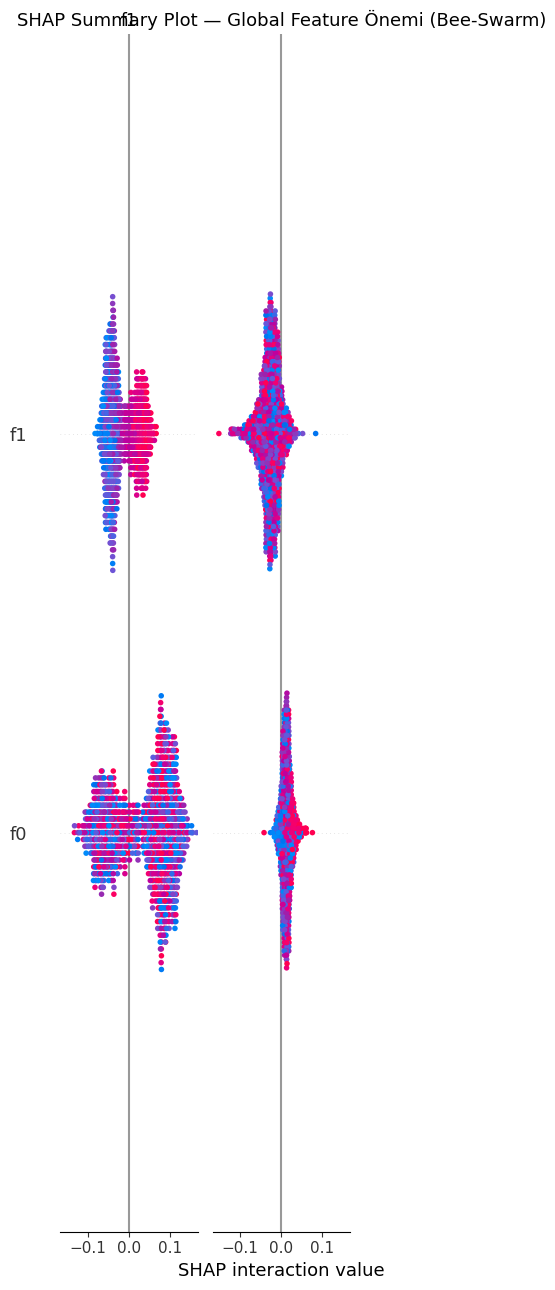

✅ Kaydedildi: 06_shap_summary_swarm.png


In [12]:
# ─────────────────────────────────────────────────────────────
# 5. GÖRSELLEŞTİRME 1: SUMMARY PLOT (Bee-Swarm)
# ─────────────────────────────────────────────────────────────
print("\n" + "─" * 50)
print("📊 Görselleştirme 1: Summary Plot (Bee-Swarm)")
print("─" * 50)
print("✏️ Nasıl okunur?")
print("   - Y ekseni: Feature önem sırası (yukarı = daha önemli)")
print("   - X ekseni: SHAP değeri (sağ = tahmin olasılığını artırır)")
print("   - Renk: Feature değeri (kırmızı=yüksek, mavi=düşük)")

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_vals_pos,
    X_test_df,
    max_display=15,
    show=False
)
plt.title("SHAP Summary Plot — Global Feature Önemi (Bee-Swarm)", fontsize=13)
plt.tight_layout()
plt.savefig("06_shap_summary_swarm.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close()
print("✅ Kaydedildi: 06_shap_summary_swarm.png")



📊 Görselleştirme 2: Bar Plot (Ortalama |SHAP| değerleri)


<Figure size 1000x600 with 0 Axes>

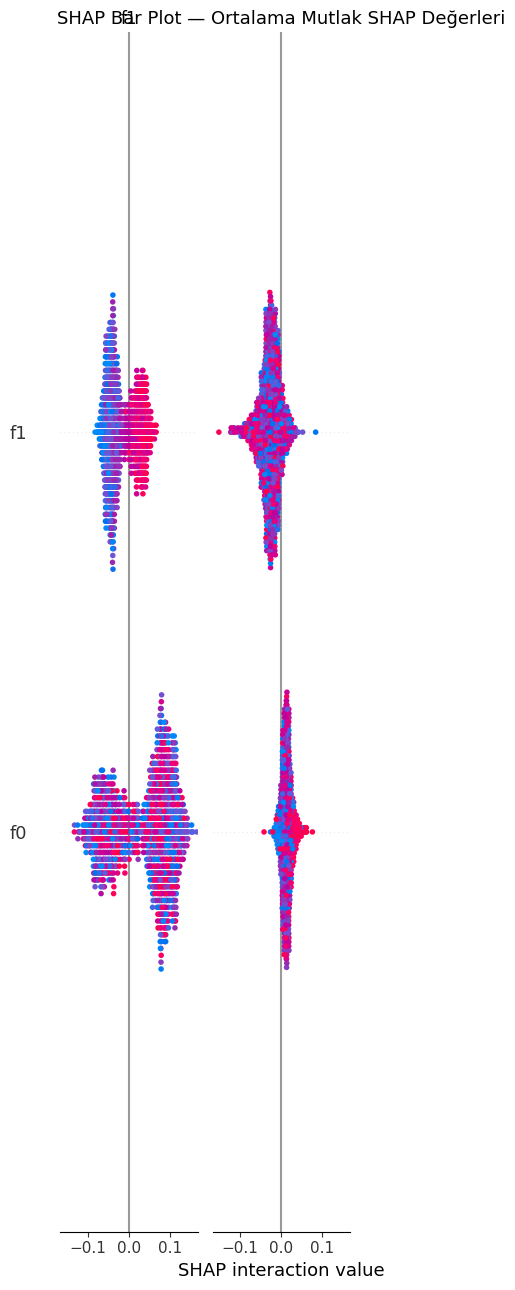

✅ Kaydedildi: 06_shap_bar.png


In [13]:
# ─────────────────────────────────────────────────────────────
# 6. GÖRSELLEŞTİRME 2: BAR PLOT (Ortalama |SHAP|)
# ─────────────────────────────────────────────────────────────
print("\n📊 Görselleştirme 2: Bar Plot (Ortalama |SHAP| değerleri)")
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_vals_pos,
    X_test_df,
    plot_type="bar",
    max_display=15,
    show=False
)
plt.title("SHAP Bar Plot — Ortalama Mutlak SHAP Değerleri", fontsize=13)
plt.tight_layout()
plt.savefig("06_shap_bar.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close()
print("✅ Kaydedildi: 06_shap_bar.png")



📊 Görselleştirme 3: Waterfall Plot (Bireysel tahmin analizi)


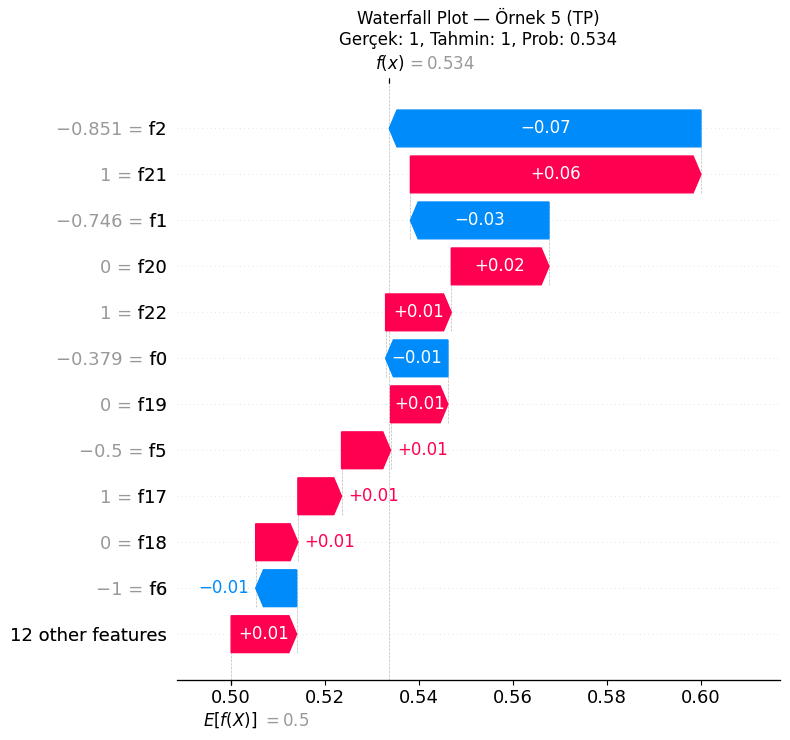

✅ Kaydedildi: 06_shap_waterfall_tp.png (TP)


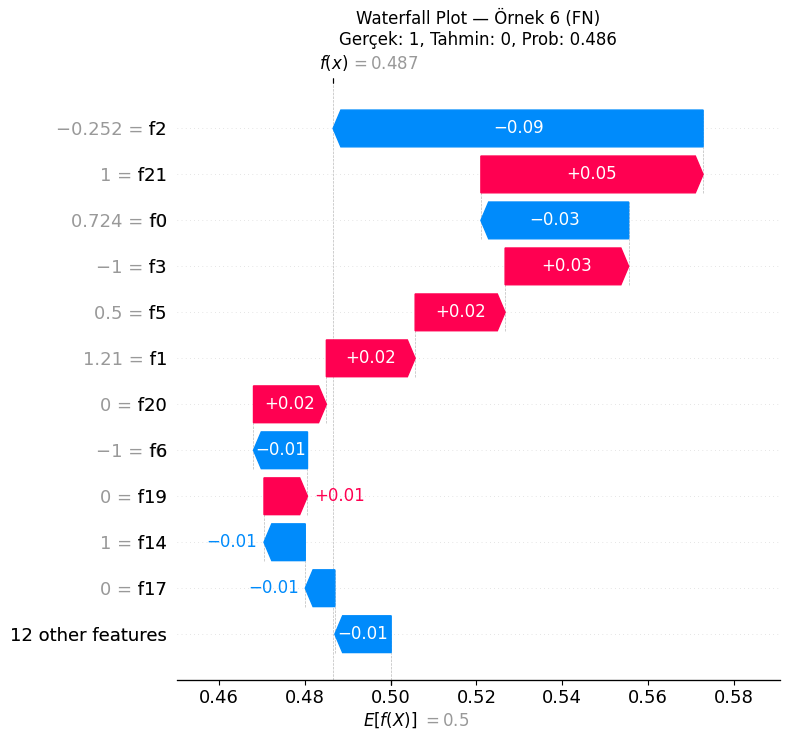

✅ Kaydedildi: 06_shap_waterfall_fn.png (FN)


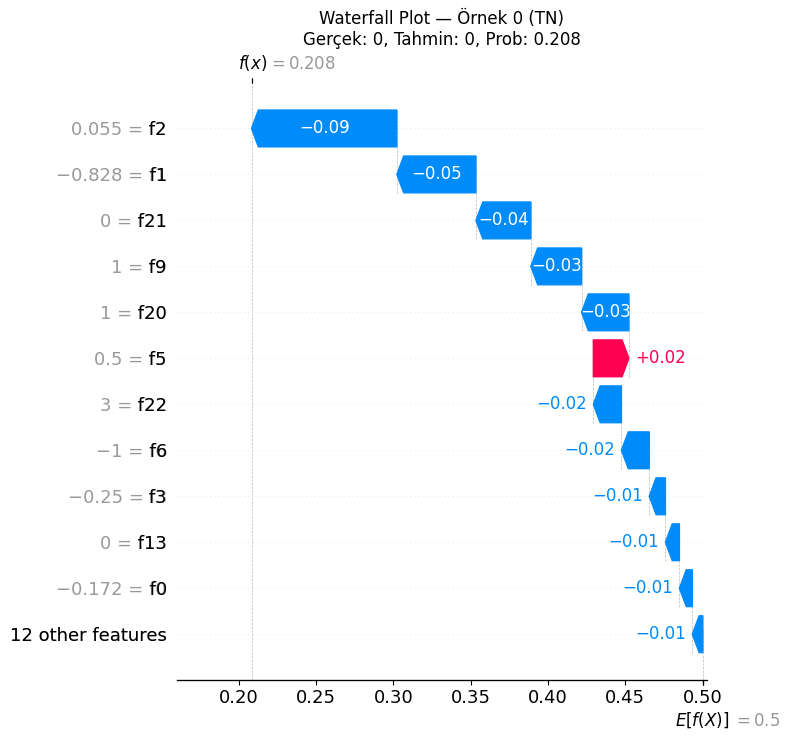

✅ Kaydedildi: 06_shap_waterfall_tn.png (TN)


In [15]:
# ─────────────────────────────────────────────────────────────
# 7. GÖRSELLEŞTİRME 3: WATERFALL PLOT
# ─────────────────────────────────────────────────────────────
print("\n📊 Görselleştirme 3: Waterfall Plot (Bireysel tahmin analizi)")

pos_class = 1

# Tahminler
y_pred_test = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

true_pos_idx  = np.where((y_test.values == 1) & (y_pred_test == 1))[0]
false_neg_idx = np.where((y_test.values == 1) & (y_pred_test == 0))[0]
true_neg_idx  = np.where((y_test.values == 0) & (y_pred_test == 0))[0]

example_indices = []
for arr, label in [(true_pos_idx, "TP"), (false_neg_idx, "FN"), (true_neg_idx, "TN")]:
    if len(arr) > 0:
        example_indices.append((int(arr[0]), label))

# expected_val bazen skalar bazen [base0, base1]
base = expected_val
if hasattr(base, "__len__") and not np.isscalar(base):
    base = base[pos_class]
base = float(np.array(base).reshape(-1)[0])

for sample_idx, label in example_indices:
    # ---- FIX: SHAP değerlerini tek sınıfa indir ----
    vals = shap_vals_pos[sample_idx]

    # vals shape (n_features, 2) ise pozitif sınıfı seç -> (n_features,)
    if getattr(vals, "ndim", 1) == 2 and vals.shape[1] == 2:
        vals = vals[:, pos_class]

    exp = shap.Explanation(
        values=vals,                              # (n_features,)
        base_values=base,                         # skalar
        data=X_test_df.iloc[sample_idx].values,   # (n_features,)
        feature_names=X_test_df.columns,          # doğru isimler
    )

    plt.figure(figsize=(10, 7))
    shap.plots.waterfall(exp, max_display=12, show=False)
    plt.title(
        f"Waterfall Plot — Örnek {sample_idx} ({label})\n"
        f"Gerçek: {y_test.values[sample_idx]}, Tahmin: {y_pred_test[sample_idx]}, "
        f"Prob: {y_proba[sample_idx]:.3f}",
        fontsize=12
    )
    plt.tight_layout()
    plt.savefig(f"06_shap_waterfall_{label.lower()}.png", dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

    print(f"✅ Kaydedildi: 06_shap_waterfall_{label.lower()}.png ({label})")

plt.close("all")


📊 Görselleştirme 4: Force Plot (İlk True Positive)


<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

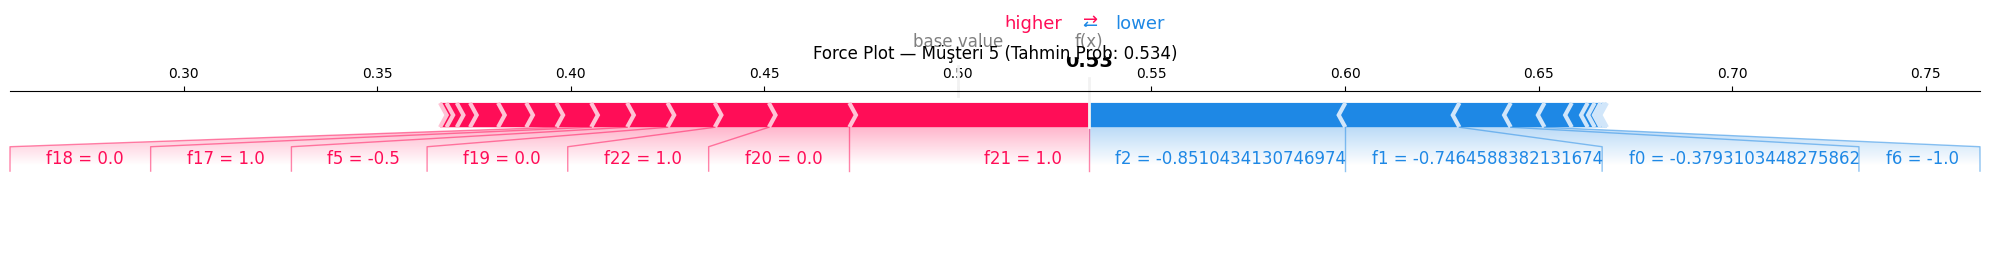

✅ Kaydedildi: 06_shap_force.png


In [18]:
# ─────────────────────────────────────────────────────────────
# 8. GÖRSELLEŞTİRME 4: FORCE PLOT
# ─────────────────────────────────────────────────────────────
print("\n📊 Görselleştirme 4: Force Plot (İlk True Positive)")

pos_class = 1  # churn=1

if len(true_pos_idx) > 0:
    tp_idx = int(true_pos_idx[0])

    # base değer skalar olsun
    base = expected_val
    if hasattr(base, "__len__") and not np.isscalar(base):
        base = base[pos_class]
    base = float(np.array(base).reshape(-1)[0])

    # SHAP değerleri 1D olsun (n_features,)
    vals = shap_vals_pos[tp_idx]
    if getattr(vals, "ndim", 1) == 2 and vals.shape[1] == 2:
        vals = vals[:, pos_class]

    plt.figure(figsize=(14, 4))
    shap.force_plot(
        base,
        vals,
        X_test_df.iloc[tp_idx].values,     # 1D data
        feature_names=X_test_df.columns,   # isimler kesin uyumlu
        matplotlib=True,
        show=False,
    )

    plt.title(f"Force Plot — Müşteri {tp_idx} (Tahmin Prob: {y_proba[tp_idx]:.3f})", fontsize=12)
    plt.tight_layout()
    plt.savefig("06_shap_force.png", dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()
    print("✅ Kaydedildi: 06_shap_force.png")
else:
    print("⚠️ True Positive örnek bulunamadı.")



📊 Görselleştirme 5: Dependence Plot (Top feature vs interaction)
   En önemli feature: f2
   İkinci önemli feature (renk): f5


<Figure size 1000x600 with 0 Axes>

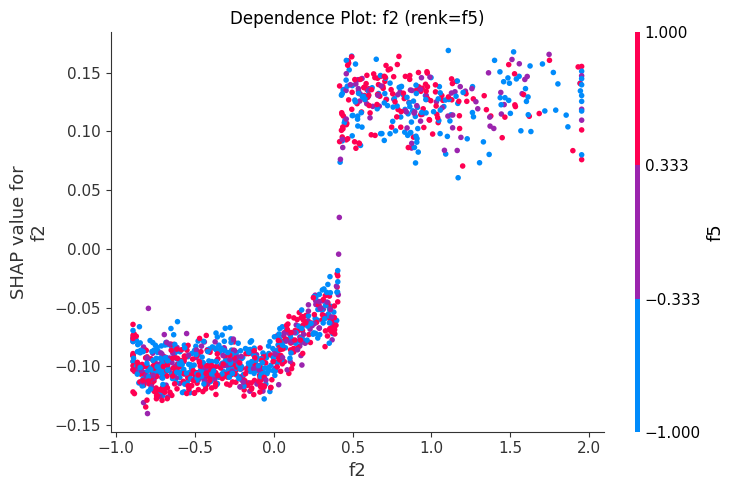

✅ Kaydedildi: 06_shap_dependence.png


In [20]:
# ─────────────────────────────────────────────────────────────
# 9. GÖRSELLEŞTİRME 5: DEPENDENCE PLOT
# ─────────────────────────────────────────────────────────────
print("\n📊 Görselleştirme 5: Dependence Plot (Top feature vs interaction)")

pos_class = 1  # churn=1

# --- FIX 1: SHAP'ı 2D hale getir (n_samples, n_features) ---
shap_mat = shap_vals_pos
if getattr(shap_mat, "ndim", 2) == 3:          # (n_samples, n_features, 2) ise
    shap_mat = shap_mat[:, :, pos_class]
elif getattr(shap_mat, "ndim", 2) == 2 and shap_mat.shape[1] == 2:
    # nadiren (n_features,2) gibi bir şey kalırsa (tek örnek), dependence için uygun değil
    raise ValueError("Dependence plot için shap_vals_pos (n_samples, n_features) olmalı.")

# --- FIX 2: feature isimlerini X_test_df'den al (kesin uyumlu) ---
feat_names = np.array(X_test_df.columns)

# En önemli feature'ı bul
mean_abs_shap = np.abs(shap_mat).mean(axis=0)             # (n_features,)
top_feature_idx = int(np.argmax(mean_abs_shap))           # skalar int

# Etkileşim için 2. feature (renk)
second_feature_idx = int(np.argsort(mean_abs_shap)[-2])   # en önemliden bir sonraki

top_feature = feat_names[top_feature_idx]
second_feature = feat_names[second_feature_idx]

print(f"   En önemli feature: {top_feature}")
print(f"   İkinci önemli feature (renk): {second_feature}")

plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_feature_idx,          # veya top_feature (isim de olur)
    shap_mat,
    X_test_df,
    interaction_index=second_feature_idx,
    show=False,
)
plt.title(f"Dependence Plot: {top_feature} (renk={second_feature})", fontsize=12)
plt.tight_layout()
plt.savefig("06_shap_dependence.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close()
print("✅ Kaydedildi: 06_shap_dependence.png")



📊 Görselleştirme 6: Decision Plot (100 örnek karar yolu)


<Figure size 1000x800 with 0 Axes>

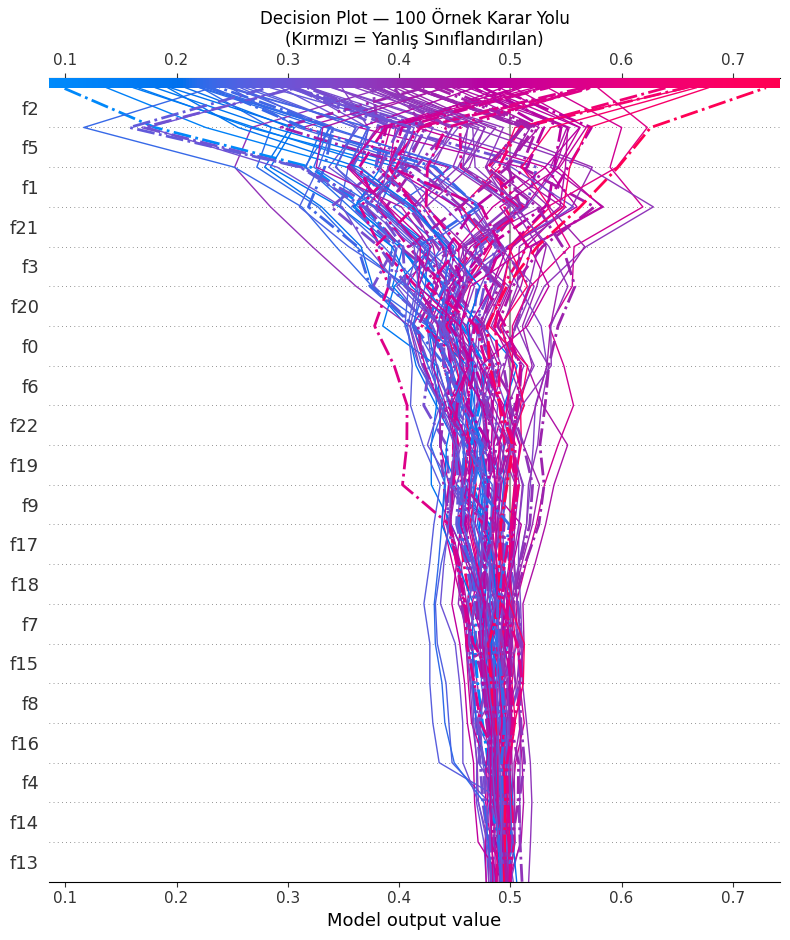

✅ Kaydedildi: 06_shap_decision.png


In [22]:
# ─────────────────────────────────────────────────────────────
# 10. GÖRSELLEŞTİRME 6: DECISION PLOT
# ─────────────────────────────────────────────────────────────
print("\n📊 Görselleştirme 6: Decision Plot (100 örnek karar yolu)")

pos_class = 1  # churn=1

# --- SHAP'ı 2D hale getir ---
shap_mat = shap_vals_pos
if getattr(shap_mat, "ndim", 2) == 3:          # (n_samples, n_features, 2)
    shap_mat = shap_mat[:, :, pos_class]

# --- expected_val skalar yap ---
base = expected_val
if hasattr(base, "__len__") and not np.isscalar(base):
    base = base[pos_class]
base = float(np.array(base).reshape(-1)[0])

# --- Feature isimleri kesin uyumlu olsun ---
feat_names = list(X_test_df.columns)

sample_n = min(100, len(X_test_df))
misclassified = np.where(y_test.values[:sample_n] != y_pred_test[:sample_n])[0]

plt.figure(figsize=(10, 8))
shap.decision_plot(
    base,
    shap_mat[:sample_n],               # (sample_n, n_features)
    X_test_df.iloc[:sample_n],         # aynı feature uzayı
    feature_names=feat_names,          # TAM uyumlu
    highlight=misclassified,
    show=False,
)

plt.title("Decision Plot — 100 Örnek Karar Yolu\n(Kırmızı = Yanlış Sınıflandırılan)", fontsize=12)
plt.tight_layout()
plt.savefig("06_shap_decision.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close()
print("✅ Kaydedildi: 06_shap_decision.png")



In [24]:
# ─────────────────────────────────────────────────────────────
# 11. SHAP INTERACTION VALUES (Gelişmiş)
# ─────────────────────────────────────────────────────────────
print("\n" + "─" * 50)
print("🔬 Gelişmiş: SHAP Interaction Values")
print("─" * 50)
print("⏳ İlk 200 test örneği için hesaplanıyor...")

sample_size = min(200, len(X_test_df))
try:
    shap_interaction = explainer.shap_interaction_values(X_test_df.iloc[:sample_size])
    if isinstance(shap_interaction, list):
        shap_interaction = shap_interaction[1]

    # En güçlü etkileşim çiftlerini bul
    n_feat = shap_interaction.shape[1]
    interaction_matrix = np.abs(shap_interaction).mean(axis=0)
    np.fill_diagonal(interaction_matrix, 0)
    top_pairs = []
    for i in range(n_feat):
        for j in range(i + 1, n_feat):
            top_pairs.append((interaction_matrix[i, j], i, j))
    top_pairs.sort(reverse=True)

    print("\n🔥 En Güçlü Feature Etkileşimleri (Top 5):")
    for val, i, j in top_pairs[:5]:
        fn_i = feature_names_short[i] if i < len(feature_names_short) else f"F{i}"
        fn_j = feature_names_short[j] if j < len(feature_names_short) else f"F{j}"
        print(f"   {fn_i} ↔ {fn_j}: {val:.4f}")

    # Interaction heatmap
    n_show = min(12, n_feat)
    top_feat_idx = np.argsort(np.abs(shap_vals_pos).mean(axis=0))[-n_show:]
    sub_matrix = interaction_matrix[np.ix_(top_feat_idx, top_feat_idx)]
    sub_names = [feature_names_short[i] if i < len(feature_names_short) else f"F{i}"
                 for i in top_feat_idx]

    plt.figure(figsize=(10, 8))
    sns_data = pd.DataFrame(sub_matrix, index=sub_names, columns=sub_names)
    import seaborn as sns
    sns.heatmap(sns_data, cmap="YlOrRd", annot=True, fmt=".3f", linewidths=0.5,
                cbar_kws={"label": "Ortalama |Etkileşim SHAP|"})
    plt.title("SHAP Interaction Values Heatmap\n(Özellikler Arası Etkileşim Gücü)", fontsize=13)
    plt.xticks(rotation=30, ha="right", fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.savefig("06_shap_interaction_heatmap.png", dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()
    print("✅ Kaydedildi: 06_shap_interaction_heatmap.png")
except Exception as e:
    print(f"⚠️ Interaction values hesaplanamadı: {e}")
    print("   Bu genellikle bellek veya model uyumsuzluğu nedeniyle olur.")



──────────────────────────────────────────────────
🔬 Gelişmiş: SHAP Interaction Values
──────────────────────────────────────────────────
⏳ İlk 200 test örneği için hesaplanıyor...
⚠️ Interaction values hesaplanamadı: All dimensions of input must be of equal length
   Bu genellikle bellek veya model uyumsuzluğu nedeniyle olur.


In [26]:
# ─────────────────────────────────────────────────────────────
# 12. YANLIŞ SINIFLANDIRILAN ÖRNEKLERİN SHAP ANALİZİ
# ─────────────────────────────────────────────────────────────
print("\n" + "─" * 50)
print("🔍 Yanlış Sınıflandırılan Örneklerin SHAP Analizi")
print("─" * 50)

pos_class = 1  # churn=1

fp_idx = np.where((y_test.values == 0) & (y_pred_test == 1))[0]  # False Positive
fn_idx = np.where((y_test.values == 1) & (y_pred_test == 0))[0]  # False Negative

print(f"\n  False Positives (FP): {len(fp_idx)} örnek → Modelin 'evet' dediği ama 'hayır' olanlar")
print(f"  False Negatives (FN): {len(fn_idx)} örnek → Modelin 'hayır' dediği ama 'evet' olanlar")

# --- FIX 1: SHAP'ı tek sınıf ve 2D hale getir ---
shap_mat = shap_vals_pos
if getattr(shap_mat, "ndim", 2) == 3:          # (n_samples, n_features, 2)
    shap_mat = shap_mat[:, :, pos_class]

# Eğer yanlışlıkla hala 4D bir şey geldiyse (n_samples,n_features,2,2 gibi), güvenli indirgeme:
while getattr(shap_mat, "ndim", 2) > 2:
    shap_mat = shap_mat[..., pos_class]

# --- FIX 2: Feature isimleri kesin uyumlu olsun ---
feat_names = np.array(X_test_df.columns)  # (n_features,)

if len(fp_idx) > 0 and len(fn_idx) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    for ax_i, (indices, title, cmap_name) in enumerate([
        (fp_idx[:30], "False Positives (Yanlış Alarm)", "Reds"),
        (fn_idx[:30], "False Negatives (Kaçırılan Churn)", "Blues"),
    ]):
        # indices boş olabilir; güvenli kontrol
        if len(indices) == 0:
            axes[ax_i].set_title(title + "\n(örnek yok)", fontweight="bold", fontsize=11)
            axes[ax_i].axis("off")
            continue

        mean_shap = np.abs(shap_mat[indices]).mean(axis=0)  # (n_features,)
        top_n = 10
        top_idx = np.argsort(mean_shap)[-top_n:]            # (top_n,)

        values = mean_shap[top_idx]                         # (top_n,)
        labels = feat_names[top_idx]                        # (top_n,)

        # daha okunaklı: küçükten büyüğe sırala
        order = np.argsort(values)
        values = values[order]
        labels = labels[order]

        axes[ax_i].barh(
            range(top_n),
            values,
            color=plt.cm.get_cmap(cmap_name)(np.linspace(0.4, 0.9, top_n))
        )
        axes[ax_i].set_yticks(range(top_n))
        axes[ax_i].set_yticklabels(labels, fontsize=9)
        axes[ax_i].set_xlabel("Ortalama |SHAP|")
        axes[ax_i].set_title(title, fontweight="bold", fontsize=11)
        axes[ax_i].grid(axis="x", alpha=0.3)

    plt.suptitle("Yanlış Sınıflandırılan Örneklerde Hangi Feature'lar Baskın?",
                 fontsize=13, y=1.01)
    plt.tight_layout()
    plt.savefig("06_shap_misclassified.png", dpi=150, bbox_inches="tight")
    plt.close()
    print("✅ Kaydedildi: 06_shap_misclassified.png")

else:
    print("⚠️ FP veya FN örneği yok; bu nedenle karşılaştırma grafiği üretilemedi.")



──────────────────────────────────────────────────
🔍 Yanlış Sınıflandırılan Örneklerin SHAP Analizi
──────────────────────────────────────────────────

  False Positives (FP): 133 örnek → Modelin 'evet' dediği ama 'hayır' olanlar
  False Negatives (FN): 195 örnek → Modelin 'hayır' dediği ama 'evet' olanlar
✅ Kaydedildi: 06_shap_misclassified.png


In [28]:
# ─────────────────────────────────────────────────────────────
# 13. SHAP DEĞER ANALİZİ: Yorumlanabilir Bulgu Raporu
# ─────────────────────────────────────────────────────────────
print("\n" + "=" * 65)
print("📋 SHAP ANALİZ RAPORU — Yorumlanabilir Bulgular")
print("=" * 65)

pos_class = 1  # churn=1

# --- FIX 1: SHAP'i 2D hale getir ---
shap_mat = shap_vals_pos
if getattr(shap_mat, "ndim", 2) == 3:
    shap_mat = shap_mat[:, :, pos_class]

# --- FIX 2: expected_val skalar olsun ---
base = expected_val
if hasattr(base, "__len__") and not np.isscalar(base):
    base = base[pos_class]
base = float(np.array(base).reshape(-1)[0])

feat_names = np.array(X_test_df.columns)

mean_abs = np.abs(shap_mat).mean(axis=0)
top5_idx = np.argsort(mean_abs)[-5:][::-1]

print("\n🔝 En Etkili 5 Feature:")

for rank, i in enumerate(top5_idx, 1):
    fname = feat_names[i]

    col_vals = shap_mat[:, i]

    pos_vals = col_vals[col_vals > 0]
    neg_vals = col_vals[col_vals < 0]

    pos_mean = pos_vals.mean() if pos_vals.size > 0 else 0
    neg_mean = neg_vals.mean() if neg_vals.size > 0 else 0

    print(f"  #{rank}: {fname:<25} | Ortalama |SHAP|: {mean_abs[i]:.4f} "
          f"| Pozitif etki: {pos_mean:+.3f} | Negatif etki: {neg_mean:+.3f}")

print(f"\n  Baz değer: {base:.4f} → Modelin ortalama tahmin olasılığı")
print(f"  Örnek tahmin: {y_proba[0]:.4f} = {base:.4f} + SHAP toplamı ({(y_proba[0]-base):+.4f})")
print(f"  Kontrol: {base:.4f} + {(y_proba[0]-base):.4f} = {y_proba[0]:.4f} ✓")

print("\n  Tüm grafik dosyaları:")
for fname in [
    "06_shap_summary_swarm", "06_shap_bar", "06_shap_waterfall_tp",
    "06_shap_force", "06_shap_dependence", "06_shap_decision",
    "06_shap_interaction_heatmap", "06_shap_misclassified"
]:
    print(f"    📊 {fname}.png")

print("\n" + "=" * 65)
print(" ✅ UYGULAMA 6 TAMAMLANDI! — 8 SHAP grafiği üretildi")
print("=" * 65)



📋 SHAP ANALİZ RAPORU — Yorumlanabilir Bulgular

🔝 En Etkili 5 Feature:
  #1: f2                        | Ortalama |SHAP|: 0.1014 | Pozitif etki: +0.124 | Negatif etki: -0.092
  #2: f5                        | Ortalama |SHAP|: 0.0401 | Pozitif etki: +0.018 | Negatif etki: -0.112
  #3: f1                        | Ortalama |SHAP|: 0.0363 | Pozitif etki: +0.028 | Negatif etki: -0.041
  #4: f21                       | Ortalama |SHAP|: 0.0350 | Pozitif etki: +0.046 | Negatif etki: -0.030
  #5: f3                        | Ortalama |SHAP|: 0.0234 | Pozitif etki: +0.020 | Negatif etki: -0.025

  Baz değer: 0.5001 → Modelin ortalama tahmin olasılığı
  Örnek tahmin: 0.2080 = 0.5001 + SHAP toplamı (-0.2921)
  Kontrol: 0.5001 + -0.2921 = 0.2080 ✓

  Tüm grafik dosyaları:
    📊 06_shap_summary_swarm.png
    📊 06_shap_bar.png
    📊 06_shap_waterfall_tp.png
    📊 06_shap_force.png
    📊 06_shap_dependence.png
    📊 06_shap_decision.png
    📊 06_shap_interaction_heatmap.png
    📊 06_shap_misclassified

In [ ]:
# Merhaba